# Part 3: Machine learning

## Ad Navigator: A tool to optimize online marketing investments 
## Insight data science project

In this notebook I am going to show a case study for prediction of outcome of future investment on a marketing campaign building a pipeline that exploits the power of machine learning. I am going to show the prediction of campaign stage 2, where the goal of the campaign stage is engage potentional customers success is measure through link clicks through rate (number of clicks divided by number of impressions). Click through rate (CTR) measures the rate of people who visited the website after clicking on the Facebook ad.

I developed a web app using Flask that has this code in the back end (with slight modifications where some of the variables are user input).

In [1]:
import pandas as pd
from pandas import ExcelFile, ExcelWriter
from datetime import date, timedelta, datetime
import numpy as np


In [2]:
#Reading the last file in the record, where all the campaigns have 28 days of observations after the initial date

df1 = pd.read_csv('data_csv_files/2018-01-08.csv',skiprows=2)


In [3]:
#Dropping all the features that we are not interested in

df1 = df1[['CPC (cost per link click) (USD)','Campaign name','Ad set name','Ad name','Reporting starts','Amount spent (USD)','Reach','CTR (link click-through rate)','Link clicks','CPM (cost per 1,000 impressions) (USD)']]
df1.index = df1["Reporting starts"]
del df1["Reporting starts"]

df1.head()


,CPC (cost per link click) (USD),Campaign name,Ad set name,Ad name,Amount spent (USD),Reach,CTR (link click-through rate),Link clicks,"CPM (cost per 1,000 impressions) (USD)"
Reporting starts,,,,,,,,,
2017-09-21,2.290000,STAGE01 - EDUCATION,STG1_1%2%LAL_Best_Customers - Wrapped,EXP_SmartDesign_00,16.03,1065,0.655431,7.0,15.009363
2017-09-21,0.994086,STAGE01 - EDUCATION,STG1_0%1%LAL_Best_Customers - Wrapped,Apartment_Therapy_A,92.45,3978,2.316891,93.0,23.031888
2017-09-21,0.948205,STAGE00 - AWARENESS,STG0_2%6%LAL_Best_Customers,Apartment_Therapy_A,36.98,1485,2.620968,39.0,24.852151
2017-09-21,1.238000,STAGE00 - AWARENESS,STG0_6%10%LAL_Best_Customers,EXP_SmartDesign_00,6.19,525,0.950570,5.0,11.768061
2017-09-21,1.821250,STAGE01 - EDUCATION,STG1_MoversCollegeGradSimPages,Apartment_Therapy_A,14.57,498,1.590457,8.0,28.966203


In [4]:
#Merging campaign stages that have double entries into 1 because the overall purpose of the campaign stage is the same
#Counting how many observations are in each stage

df2 = df1.copy()

df2["Campaign name"]=df2["Campaign name"].str.replace('STAGE01 - EDUCATION','STG1')
df2["Campaign name"]=df2["Campaign name"].str.replace('STAGE01 - LEAD GENERATION','STG1')
df2["Campaign name"]=df2["Campaign name"].str.replace('STAGE00 - AWARENESS','STG0')
df2["Campaign name"]=df2["Campaign name"].str.replace('STAGE02 - VALIDATION','STG2')
df2["Campaign name"]=df2["Campaign name"].str.replace('STAGE03 - CONVERSION','STG3')
df2["Campaign name"]=df2["Campaign name"].str.replace('STG3 - DYNAMIC','STG3')
df2["Campaign name"]=df2["Campaign name"].str.replace('STG2 - DYNAMIC','STG2')

df2["Campaign name"].value_counts()

STG1    1856
STG2    1506
STG3     915
STG0     227
Name: Campaign name, dtype: int64

In [5]:
#Doing some data cleaning, then selecting which campaign stage we want to predict, in this case stage 02

dfc=df2.copy()
dfc["Amount spent (USD)"]=dfc["Amount spent (USD)"].astype(float).fillna(0)
dfc["Reach"]=dfc["Reach"].astype(float).fillna(0)
dfc["CPM (cost per 1,000 impressions) (USD)"]=dfc["CPM (cost per 1,000 impressions) (USD)"].astype(float).fillna(0)
dfc["Link clicks"]=dfc["Link clicks"].astype(float).fillna(0)
dfc["CTR (link click-through rate)"]=dfc["CTR (link click-through rate)"].astype(float).fillna(0)
dfc["CPC (cost per link click) (USD)"]=dfc["CPC (cost per link click) (USD)"].astype(float).fillna(0)

campa = "STG2"
value_list=[campa]
dfc = dfc[dfc["Campaign name"].isin(value_list)]


In [6]:
#Making sure there are enough observations

print(len(dfc))

1506


At the beginning of the campaign only a few input variables are known to the user. This include the budget they want to allocate ("amount spent"), the ad set name (targeting of the audience they want to do), plus cost per 1,000 impressions (CPM) and reach which are estimated by facebook based on the allocated budget and ad set name. Note for CPM: this variable refers to how targeted they want the add to be. The higher the CPM the more targeted their audience will be. The end goal is to find the right combination to minimize CPM and maximize link clicks-through rate (CTR).

Below I am computing cross-correlations in the dataframe. Among the data that are available to the company at the beginning of the campaign, only CPM is moderately correlated to CTR. However, since we are going to turn this into a classification problem (success/not success of the campaign), there could hidden correlations among the other features that could lead to actionable insights that cannot be seen from simple correlations.

In [7]:
#Computing the matrix of cross-correlations for an initial evaluation of the data

dfc.corr()

,CPC (cost per link click) (USD),Amount spent (USD),Reach,CTR (link click-through rate),Link clicks,"CPM (cost per 1,000 impressions) (USD)"
CPC (cost per link click) (USD),1.000000,0.210210,0.219497,-0.142409,-0.041974,-0.065192
Amount spent (USD),0.210210,1.000000,0.939551,0.035035,0.841752,0.033293
Reach,0.219497,0.939551,1.000000,0.019153,0.868590,-0.113896
CTR (link click-through rate),-0.142409,0.035035,0.019153,1.000000,0.175752,0.173633
Link clicks,-0.041974,0.841752,0.868590,0.175752,1.000000,-0.003125
"CPM (cost per 1,000 impressions) (USD)",-0.065192,0.033293,-0.113896,0.173633,-0.003125,1.000000


The higher the CTR the more successful the campaign was. There majority of data has small values of CTR and we want to find the characteristics that increase the CTR to optimize future investments.



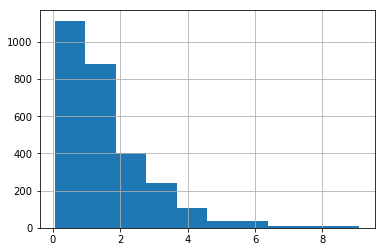

In [8]:
#Showing the frequency of CTR. 
%matplotlib inline

df2[df2['CTR (link click-through rate)'] < 10.]['CTR (link click-through rate)'].hist()


Dividing data into quantiles is a good practice to turn this into a classification problem. Here I want to single out the very successful previous advertisements to find the common characteristics that made them successful.

I decided to label all observations above the 75th percentile successful and all the ones below as average (not successful). I will be using machine learning to build a model that predicts successful events.

In [13]:
#Printing quantiles

df2 = dfc.copy()
df2[df2['CTR (link click-through rate)'] < 10.]['CTR (link click-through rate)'].quantile([0.25,0.5,0.75])

firstq,median,lastq = df2['CTR (link click-through rate)'].quantile([0.25,0.5,0.75])
print(firstq,median,lastq)

0.0 0.40315900000000005 0.9707429999999999


In [14]:
#Printing the number of > 75th percentile events and below 75th to make sure there is enough data in both categories
#To make my model more robust I should go and undersample the category that has more observations (below 75th)

print(len(df2[df2['CTR (link click-through rate)'] > lastq]))
print(len(df2[df2['CTR (link click-through rate)'] < lastq]))


377
1129


In [15]:
#Assigning categorical values (1=success, 0=average) to data, transforming this from a regression to a classification
#problem

def f(row):
    if row['CTR (link click-through rate)'] > lastq:
        val = 1
    elif row['CTR (link click-through rate)'] < lastq:
        val = 0
    return val
df2['Success'] = df2.apply(f, axis=1)

df2.head()

,CPC (cost per link click) (USD),Campaign name,Ad set name,Ad name,Amount spent (USD),Reach,CTR (link click-through rate),Link clicks,"CPM (cost per 1,000 impressions) (USD)",Success
Reporting starts,,,,,,,,,,
2017-09-21,0.00,STG2,STG2_07DayVisitor_Wrapped,TST_Compilation_00,0.71,31.0,0.000000,0.0,22.903226,0
2017-09-21,0.64,STG2,STG2_07DayVisitor_Wrapped,Apartment_Therapy_A,4.48,201.0,3.431373,7.0,21.960784,1
2017-09-21,1.99,STG2,STG2_01DayVisitor_Wrapped,LifeHacker_B,1.99,65.0,1.538462,1.0,30.615385,1
2017-09-21,0.00,STG2,STG2_07DayVisitor_Wrapped,EXP_Modular_00,0.36,20.0,0.000000,0.0,18.000000,0
2017-09-21,0.00,STG2,STG2_30DayArticleReaderRetargeting,BlogCycle_GOCO_LoveandLaRock_Delineate,0.46,14.0,0.000000,0.0,30.666667,0


One of our features has strings as values ("ad set name"). Before we can pass it to a machine learning algorithm we need to perform one-hot encoding. New columns will be added to the dataframe in this process that will containg the information contained in the ad set name but in terms of ones and zeros. Specifically, if there were N unique strings in ad set name then there will be N new columns in which the value is 1 only if that particular string is true in the observations, otherwise is 0.

In [16]:
#one-hot encoding

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

data = df2.copy()

label_encoder   = LabelEncoder()
onehot_encoder  = OneHotEncoder(sparse=False)

integer_encoded1= label_encoder.fit_transform(data["Ad set name"])
integer_encoded1= integer_encoded1.reshape(len(integer_encoded1), 1)
onehot_encoded1= onehot_encoder.fit_transform(integer_encoded1)

onehot1         = pd.DataFrame(onehot_encoded1)
onehot1.index   = data.index

frames = [data,onehot1]
result = pd.concat(frames,axis=1)

result.head()

,CPC (cost per link click) (USD),Campaign name,Ad set name,Ad name,Amount spent (USD),Reach,CTR (link click-through rate),Link clicks,"CPM (cost per 1,000 impressions) (USD)",Success,...,13,14,15,16,17,18,19,20,21,22
Reporting starts,,,,,,,,,,,,,,,,,,,,,
2017-09-21,0.00,STG2,STG2_07DayVisitor_Wrapped,TST_Compilation_00,0.71,31.0,0.000000,0.0,22.903226,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-21,0.64,STG2,STG2_07DayVisitor_Wrapped,Apartment_Therapy_A,4.48,201.0,3.431373,7.0,21.960784,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-21,1.99,STG2,STG2_01DayVisitor_Wrapped,LifeHacker_B,1.99,65.0,1.538462,1.0,30.615385,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-21,0.00,STG2,STG2_07DayVisitor_Wrapped,EXP_Modular_00,0.36,20.0,0.000000,0.0,18.000000,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-21,0.00,STG2,STG2_30DayArticleReaderRetargeting,BlogCycle_GOCO_LoveandLaRock_Delineate,0.46,14.0,0.000000,0.0,30.666667,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that the data is ready, we can proceed with machine learning. First thing to do is to split the initial dataset into train and test sets. The various machine learning algorithms we will try will be trained on the train split (80% of the initial data) and validated on the test set (20% of the initial data)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

result2=result.copy()
sets = result2.copy()

#dropping all unnecessary columns in the features (X), retaining only the user input variables (see dataframe below)
#creating y, the label set with the only column being our targets (success or not)
X = sets.drop(columns=['Success','Ad name','Campaign name','Ad set name','CTR (link click-through rate)','CPC (cost per link click) (USD)','Link clicks'])
y = sets[["Success"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=87)

X_train.head()


,Amount spent (USD),Reach,"CPM (cost per 1,000 impressions) (USD)",0,1,2,3,4,5,6,...,13,14,15,16,17,18,19,20,21,22
Reporting starts,,,,,,,,,,,,,,,,,,,,,
2017-12-26,0.11,2.0,55.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-10-05,5.67,152.0,32.033898,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-07,0.13,6.0,21.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2017-10-16,8.00,169.0,37.914692,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-12-11,0.91,40.0,22.195122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Now we are going to perform grid search with 5-fold cross validation to fine tune parameters of each of the supervised classification algorithms we want to try out. In this case we want to minimize both false positive (precision) and false negatives (recall) for the following reasons: we dont want to invest too much money in a potentially unsuccessful campaign (false positives) or missing the chance of selling our product by mislabeling a successful campaign as unsuccessful (false negatives). Therefore in our grid search algorithm I choose to optimize for accuracy scoring.

In [27]:
from sklearn import tree
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier



In [19]:
#grid search for random forest (functions to do this more efficiently are on the way(!!!)


parameters = {"max_depth": [2,3,4,5,6,7,8,9,10,11,12]
            ,"min_samples_split" :[2,3,4,5,6]
            ,"n_estimators" : [10]
            ,"min_samples_leaf": [1,2,3,4,5]
            ,"max_features": (1,2)
            ,"criterion": ('gini','entropy')}


clf = RandomForestClassifier(max_depth=5, random_state=12)


grid =  GridSearchCV(estimator=clf, param_grid=parameters, cv=5, scoring='accuracy', n_jobs=1)

grid.fit(X_train, y_train.values.ravel())
print (grid.best_params_)


{'n_estimators': 10, 'max_depth': 12, 'max_features': 2, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'gini'}


In [21]:
#grid search for logistic regression

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            ,"penalty": ('l1','l2')}


clf = linear_model.LogisticRegression()

grid =  GridSearchCV(estimator=clf, param_grid=parameters, cv=5, scoring='accuracy', n_jobs=1)
#optimize area under ROC curve
grid.fit(X_train, y_train.values.ravel())
print (grid.best_params_)

{'penalty': 'l1', 'C': 1}


In [22]:
#grid search for kNN

parameters = {'n_neighbors': [1, 3, 5, 7]
            }

clf = KNeighborsClassifier()

grid =  GridSearchCV(estimator=clf, param_grid=parameters, cv=5, scoring='accuracy', n_jobs=1)

grid.fit(X_train, y_train.values.ravel())
print (grid.best_params_)

{'n_neighbors': 5}


In [23]:
#grid search for SVM

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

clf = svm.SVC()

grid =  GridSearchCV(estimator=clf, param_grid=parameters, cv=5, scoring='accuracy', n_jobs=1)

grid.fit(X_train, y_train.values.ravel())
print (grid.best_params_)

{'C': 0.001}


In [35]:
#here we choose one at the time the algorithm we want to try using the best parameters we found from grid search
#function to handle this computation to come!!!!

clf = RandomForestClassifier(max_depth=12, criterion='gini', min_samples_leaf=3, min_samples_split=2, n_estimators=10, random_state=10)
#clf = KNeighborsClassifier(n_neighbors=5)
#clf = svm.SVC()#(C=0.001)
#clf = GaussianNB()
#clf = linear_model.LogisticRegression(C=1,penalty='l2')
#clf = GradientBoostingClassifier(random_state=10)
#clf = DecisionTreeClassifier()

#clf = clf.fit(X_train, y_train)
clf = clf.fit(X_train, y_train.values.ravel())
y_pred= clf.predict(X_test)



In [36]:
#Transforming predicted values into a dataframe, then concatenating predictions and labels in one dataframe

preddf = pd.DataFrame(y_pred)
ytestf = pd.DataFrame(y_test)
preddf.index=y_test.index
togeth = [ytestf,preddf]
oneonl = pd.concat(togeth,axis=1)
oneonl.columns=["Targets","Predictions"]
oneonl.head()


,Targets,Predictions
Reporting starts,,
2017-12-16,0,0
2017-10-30,0,0
2017-12-21,0,0
2017-10-03,0,0
2017-09-25,0,0


From now on I am going to compute some metrics to evaluate model performance and then making my model choice

In [37]:
#Raw values of predictions against labels in each category (0 and 1)

print(oneonl['Targets'].value_counts())
print(oneonl['Predictions'].value_counts())

0    230
1     72
Name: Targets, dtype: int64
0    256
1     46
Name: Predictions, dtype: int64


Confusion matrix, without normalization
[[217  13]
 [ 39  33]]
Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.54  0.46]]


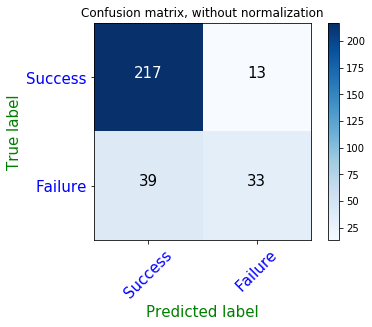

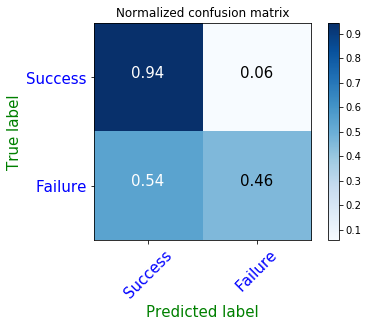

In [38]:
#Plot the confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 15, color='b')
    plt.yticks(tick_marks, classes, fontsize = 15, color='b')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=15,
                 color="white" if cm[i, j] > thresh else "black")

   # plt.tight_layout()
    plt.ylabel('True label', fontsize = 15, color='g')
    plt.xlabel('Predicted label', fontsize = 15, color='g')

# Compute confusion matrix
cnf_matrix   = confusion_matrix(y_test, y_pred)
class_names  = ["Success","Failure"]


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [39]:
#print some metrics

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("F1 score:  ",f1_score(y_test, y_pred, average="macro"))
print("Precision: ",precision_score(y_test, y_pred, average="macro"))
print("Recall:    ",recall_score(y_test, y_pred, average="macro"))   
print("Accuracy:  ",accuracy_score(y_test, y_pred))


F1 score:   0.726163074562
Precision:  0.782523777174
Recall:     0.700905797101
Accuracy:   0.827814569536


In [40]:
#and feature importance

print(clf.feature_importances_)

[ 0.18  0.17  0.2   0.02  0.03  0.    0.    0.    0.01  0.    0.01  0.
  0.02  0.    0.04  0.01  0.    0.25  0.02  0.01  0.02  0.    0.    0.    0.
  0.  ]


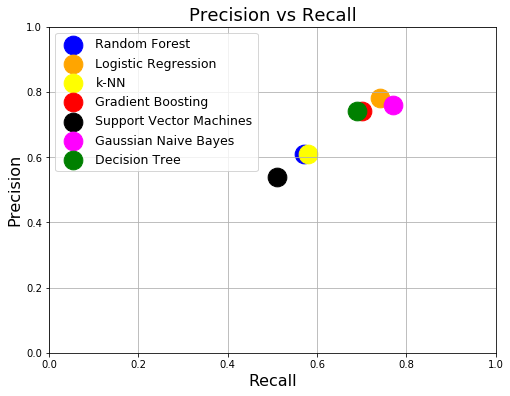

In [42]:
#making a plot of precision vs recall given pre-calculated values for each model

import pandas as pd

from matplotlib.pyplot import *
from matplotlib import colors

colorlist = ['blue', 'orange', 'yellow', 'red', 'black', 'magenta','green']

ml = ['Random Forest',
      'Logistic Regression',
      'k-NN',
      'Gradient Boosting',
      'Support Vector Machines',
      'Gaussian Naive Bayes',
      'Decision Tree',
     ]

val = [[0.61,0.57],
       [0.78,0.74],
       [0.61,0.58],
       [0.74,0.70],
       [0.54,0.51],
       [0.76,0.77],
       [0.74,0.69]
      ]

precision_recall = pd.DataFrame(data=val, 
                                index=ml,
                                columns=['Precision', 'Recall']
                               )

fig, ax = plt.subplots()

for i, l in enumerate(ml):
    precision_recall.iloc[[i]].plot(x='Recall', y='Precision', kind='scatter',
                                    figsize=(8, 6), ax=ax, s=350, label=l,
                                    color=colorlist[i], grid=True, 
                                   )

plt.title('Precision vs Recall', fontsize=18)

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)

plt.ylim(0.0, 1.0)
plt.xlim(0.0, 1.0)


plt.legend(prop={'size': 12.5}) #loc=2

plt.show()
#display(precision_recall)

For campaign stage 2 the best model is Logistic Regression, which has the highest values for both precision and recall, and also accuracy.